<a href="https://colab.research.google.com/github/vsh9/Social_Media_Data_Aggrigation/blob/main/Social_Media_Data_Aggrigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# 1. DataProcessing

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split

# Initialize Spark session
spark = SparkSession.builder.appName("DataProcessing").getOrCreate()

# Path to the text file
file_path = "/content/userdata.txt"

# Read data from the file
data = spark.read.text(file_path)

# Repartition the data into 10 partitions for parallel processing
data = data.repartition(10)

# Split the data into columns by comma
data_split = data.select(
    col("value").alias("raw_data")
).withColumn("split_data", split(col("raw_data"), ","))

# Define column names based on the expected structure
column_names = [
    "id", "first_name", "last_name", "address", "city",
    "state", "zipcode", "country", "company", "dob"
]

df = data_split.select(
    *[col("split_data").getItem(i).alias(column_names[i]) for i in range(len(column_names))]
)

df.show(truncate=False)

+-----+----------+-----------+--------------------------+---------------+------------+-------+-------+-------------+----------+
|id   |first_name|last_name  |address                   |city           |state       |zipcode|country|company      |dob       |
+-----+----------+-----------+--------------------------+---------------+------------+-------+-------+-------------+----------+
|44971|Michael   |Fry        |968 Sampson Street        |Denver         |Colorado    |80211  |US     |Brind1953    |6/7/1953  |
|23113|Avery     |Mason      |4300 Sherwood Circle      |Lafayette      |Louisiana   |70501  |US     |Gery1954     |10/10/1954|
|49984|Damien    |Lemons     |10 Ruckman Road           |Clinton        |Oklahoma    |73601  |US     |Coland       |8/12/1950 |
|5542 |Gordon    |Cook       |3545 Kelley Road          |Gulfport       |Mississippi |39507  |US     |Gintre1933   |4/1/1933  |
|10876|Daniel    |Lanier     |4322 Edgewood Road        |Memphis        |Tennessee   |38116  |US     |Wo

In [ ]:
# 2. GeographicAnalysis
spark = SparkSession.builder.appName("GeographicAnalysis").getOrCreate()

# Group by country, state, and city to see the distribution
geo_distribution = df.groupBy("country", "state", "city").count()

# Show the geographic distribution
geo_distribution.show(truncate=False)

+-------+--------------+---------------+-----+
|country|state         |city           |count|
+-------+--------------+---------------+-----+
|US     |Nevada        |Tuscarora      |1    |
|US     |Washington    |Spokane        |66   |
|US     |Georgia       |Pooler         |3    |
|US     |New Jersey    |Pennsauken     |12   |
|US     |New Hampshire |Portsmouth     |11   |
|US     |Colorado      |Weston         |2    |
|US     |South Carolina|Edisto Beach   |1    |
|US     |Ohio          |South Lebanon  |1    |
|US     |Ohio          |Westminster    |1    |
|US     |Wisconsin     |Rhinelander    |2    |
|US     |Wisconsin     |Mosinee        |3    |
|US     |Montana       |Hamilton       |4    |
|US     |Florida       |Miami          |272  |
|US     |Oklahoma      |Tulsa          |119  |
|US     |North Carolina|Shelby         |5    |
|US     |Iowa          |Spencer        |9    |
|US     |West Virginia |Weirton Heights|1    |
|US     |Illinois      |Broughton      |1    |
|US     |Minn

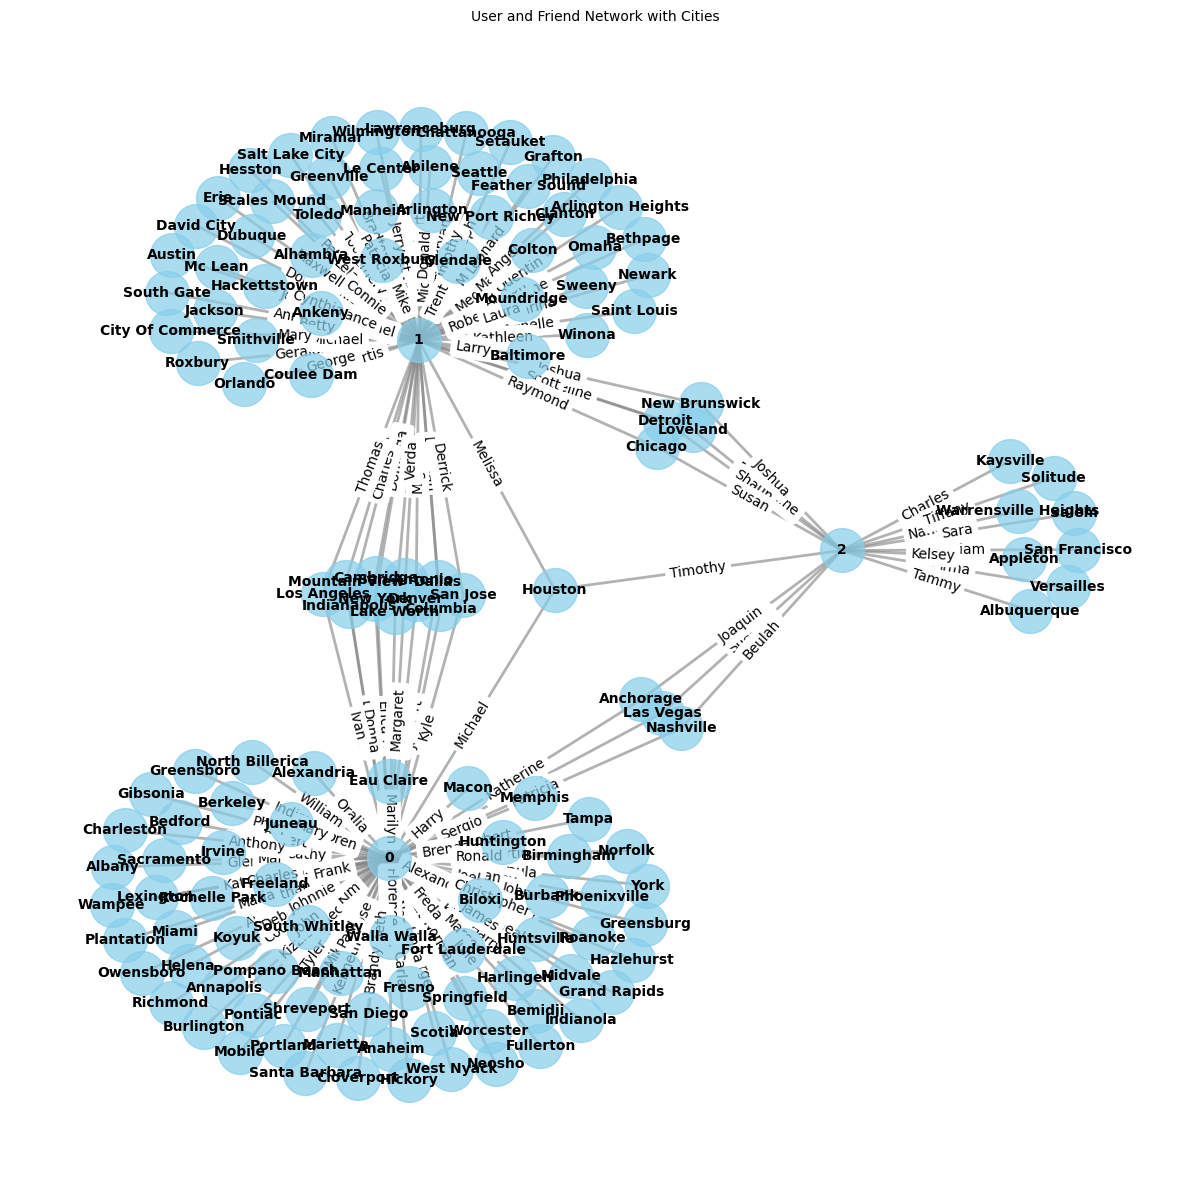

In [ ]:
# 3. InMemoryJoinCityPersonMapping
import networkx as nx
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, explode, collect_list

# Initialize Spark Session
spark = SparkSession.builder.appName("PySpark_Conversion").getOrCreate()

# Initialize SparkSession
spark = SparkSession.builder.master("local[*]").appName("InMemoryJoinCityPersonMapping").getOrCreate()

def in_memory_join_city_person_mapping(input_path, user_data_path):
    # Load main dataset
    data = spark.read.text(input_path).rdd.map(lambda row: row[0].split("\t"))

    # Load user data into a dictionary
    user_data = {}
    with open(user_data_path, "r") as f:
        for line in f:
            parts = line.strip().split(",")
            if len(parts) == 10:
                user_data[parts[0].strip()] = f"{parts[1]}:{parts[4]}"  # Store city:name

    # Broadcast user data
    broadcast_user_data = spark.sparkContext.broadcast(user_data)

    # Map operation
    def map_function(line):
        user_data = broadcast_user_data.value
        if len(line) == 2:
            user_id = line[0]
            friends = line[1].split(",")
            mapped_friends = [user_data[f] for f in friends if f in user_data]
            return user_id, mapped_friends

    # Process data
    result = data.map(map_function).collect()
    return result

def visualize_city_person_mapping_network(mapped_data):

    G = nx.Graph()

    # Add nodes and edges
    for user_id, friends in mapped_data:
        for friend in friends:
            city, name = friend.split(":")  # Separate city and name
            G.add_edge(user_id, name, label=city)  # Create an edge between user and friend with city as a label

    # Plot the network graph
    plt.figure(figsize=(12,12))

    # Use a faster layout (circular layout or reduced spring layout iterations)
    pos = nx.spring_layout(G, k=0.2, iterations=5000)
    labels = nx.get_edge_attributes(G, "label")  # Extract city labels for edges

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color="skyblue", alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.6, edge_color="gray")
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold", font_color="black")

    # Draw edge labels (cities of friends)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=10)

    # Title and plot settings
    plt.title("User and Friend Network with Cities", fontsize=10)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

input_path = "/content/data.txt"
user_data_path = "/content/userdata.txt"
mapped_data = in_memory_join_city_person_mapping(input_path, user_data_path)

# Sample the first 3 users for visualization
sampled_data = mapped_data[:3]
visualize_city_person_mapping_network(sampled_data)

<ipython-input-4-90f84b72718d>:37: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=user_pairs, y=mutual_counts, palette="Blues_d", s=100, color='blue')


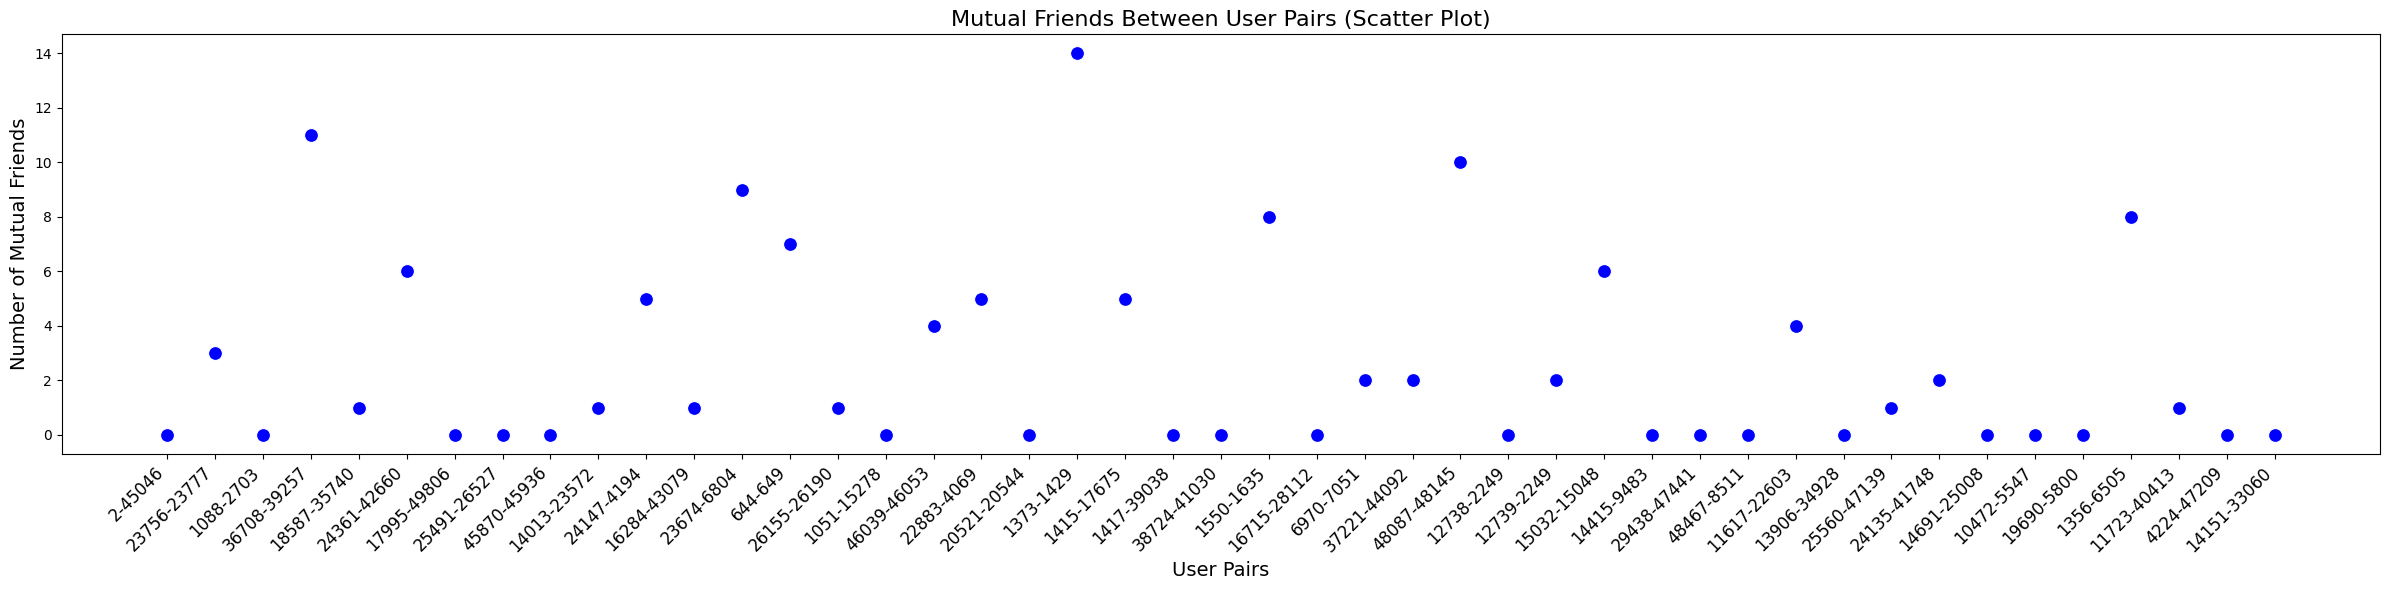

In [ ]:
# 4. MutualFriends
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("MutualFriends").getOrCreate()

def mutual_friends(input_path):
    # Load data
    data = spark.read.text(input_path).rdd.map(lambda row: row[0].split("\t")).cache()

    def map_function(line):
        if len(line) < 2:
            return []
        user = line[0]
        friends = line[1].split(",")
        pairs = []
        for friend in friends:
            if user < friend:
                pairs.append(((user, friend), set(friends)))
            else:
                pairs.append(((friend, user), set(friends)))
        return pairs

    result = data.flatMap(map_function).repartition(100).reduceByKey(lambda x, y: x.intersection(y)).mapValues(len)

    return result.take(45)

def visualize_mutual_friends_scatter(mutual_friends_data):
    # Prepare data for visualization
    user_pairs = [f"{pair[0]}-{pair[1]}" for pair, mutual_count in mutual_friends_data]
    mutual_counts = [mutual_count for pair, mutual_count in mutual_friends_data]

    # Create scatter plot
    plt.figure(figsize=(24, 6))
    sns.scatterplot(x=user_pairs, y=mutual_counts, palette="Blues_d", s=100, color='blue')

    # Adding labels
    plt.title("Mutual Friends Between User Pairs (Scatter Plot)", fontsize=16)
    plt.xlabel("User Pairs", fontsize=14)
    plt.ylabel("Number of Mutual Friends", fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.tight_layout()
    plt.show()


input_path = "/content/data.txt"
mutual_friends_data = mutual_friends(input_path)
visualize_mutual_friends_scatter(mutual_friends_data)

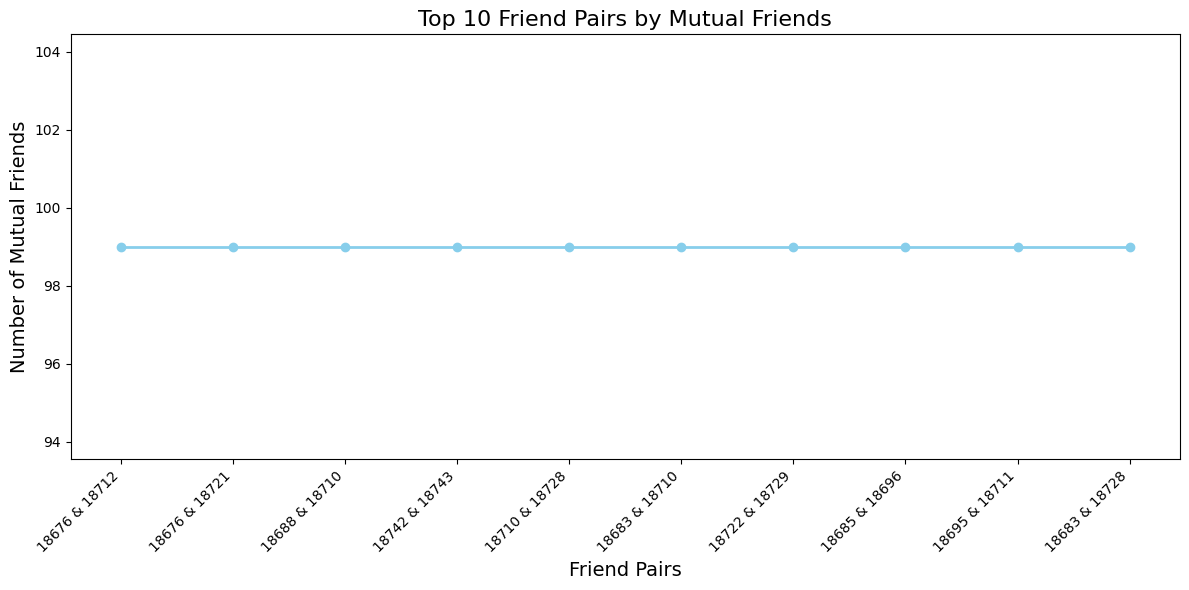

In [ ]:
# 5. MyTopTenFriends
def my_top_ten_friends_with_visualization(input_path):
    # Initialize SparkSession
    spark = SparkSession.builder.appName("MyTopTenFriends").getOrCreate()

    # Load data
    data = spark.read.text(input_path).rdd.map(lambda row: row[0].split("\t"))

    # Map function to pair users
    def map_function(line):
        user = line[0]
        friends = line[1].split(",")
        pairs = []
        for friend in friends:
            if user < friend:
                pairs.append(((user, friend), set(friends)))
            else:
                pairs.append(((friend, user), set(friends)))
        return pairs

    # Reduce function to find mutual friends
    def reduce_function(friend_sets):
        return friend_sets[0].intersection(friend_sets[1])

    # Find top 10 friend pairs with the most mutual friends
    mutual_friends = data.flatMap(map_function)\
        .reduceByKey(lambda x, y: x.intersection(y))\
        .map(lambda x: (x[0], len(x[1]), list(x[1])))\
        .sortBy(lambda x: -x[1])\
        .take(10)

    # Extract data for visualization
    pairs = [f"{pair[0][0]} & {pair[0][1]}" for pair in mutual_friends]
    mutual_counts = [pair[1] for pair in mutual_friends]

    # Visualization
    def visualize_results(pairs, mutual_counts):
        plt.figure(figsize=(12, 6))
        plt.plot(pairs, mutual_counts, marker='o', color='skyblue', linestyle='-', linewidth=2)
        plt.xlabel('Friend Pairs', fontsize=14)
        plt.ylabel('Number of Mutual Friends', fontsize=14)
        plt.title('Top 10 Friend Pairs by Mutual Friends', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    visualize_results(pairs, mutual_counts)

    return mutual_friends

result = my_top_ten_friends_with_visualization('/content/data.txt')